In [1]:
# 加载相关数据库
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") #用于排除警告
from sklearn.decomposition import PCA #主成分降维
from sklearn.preprocessing import StandardScaler #数据标准化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# 首先展示复现


In [2]:
# 1获取数据
name=['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight'
      ,'Rings']
print(name)
df = pd.read_csv("./data/abalone.data",header=None,names=name)
display(df.tail(3))
data=df

['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.308,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.296,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.495,12


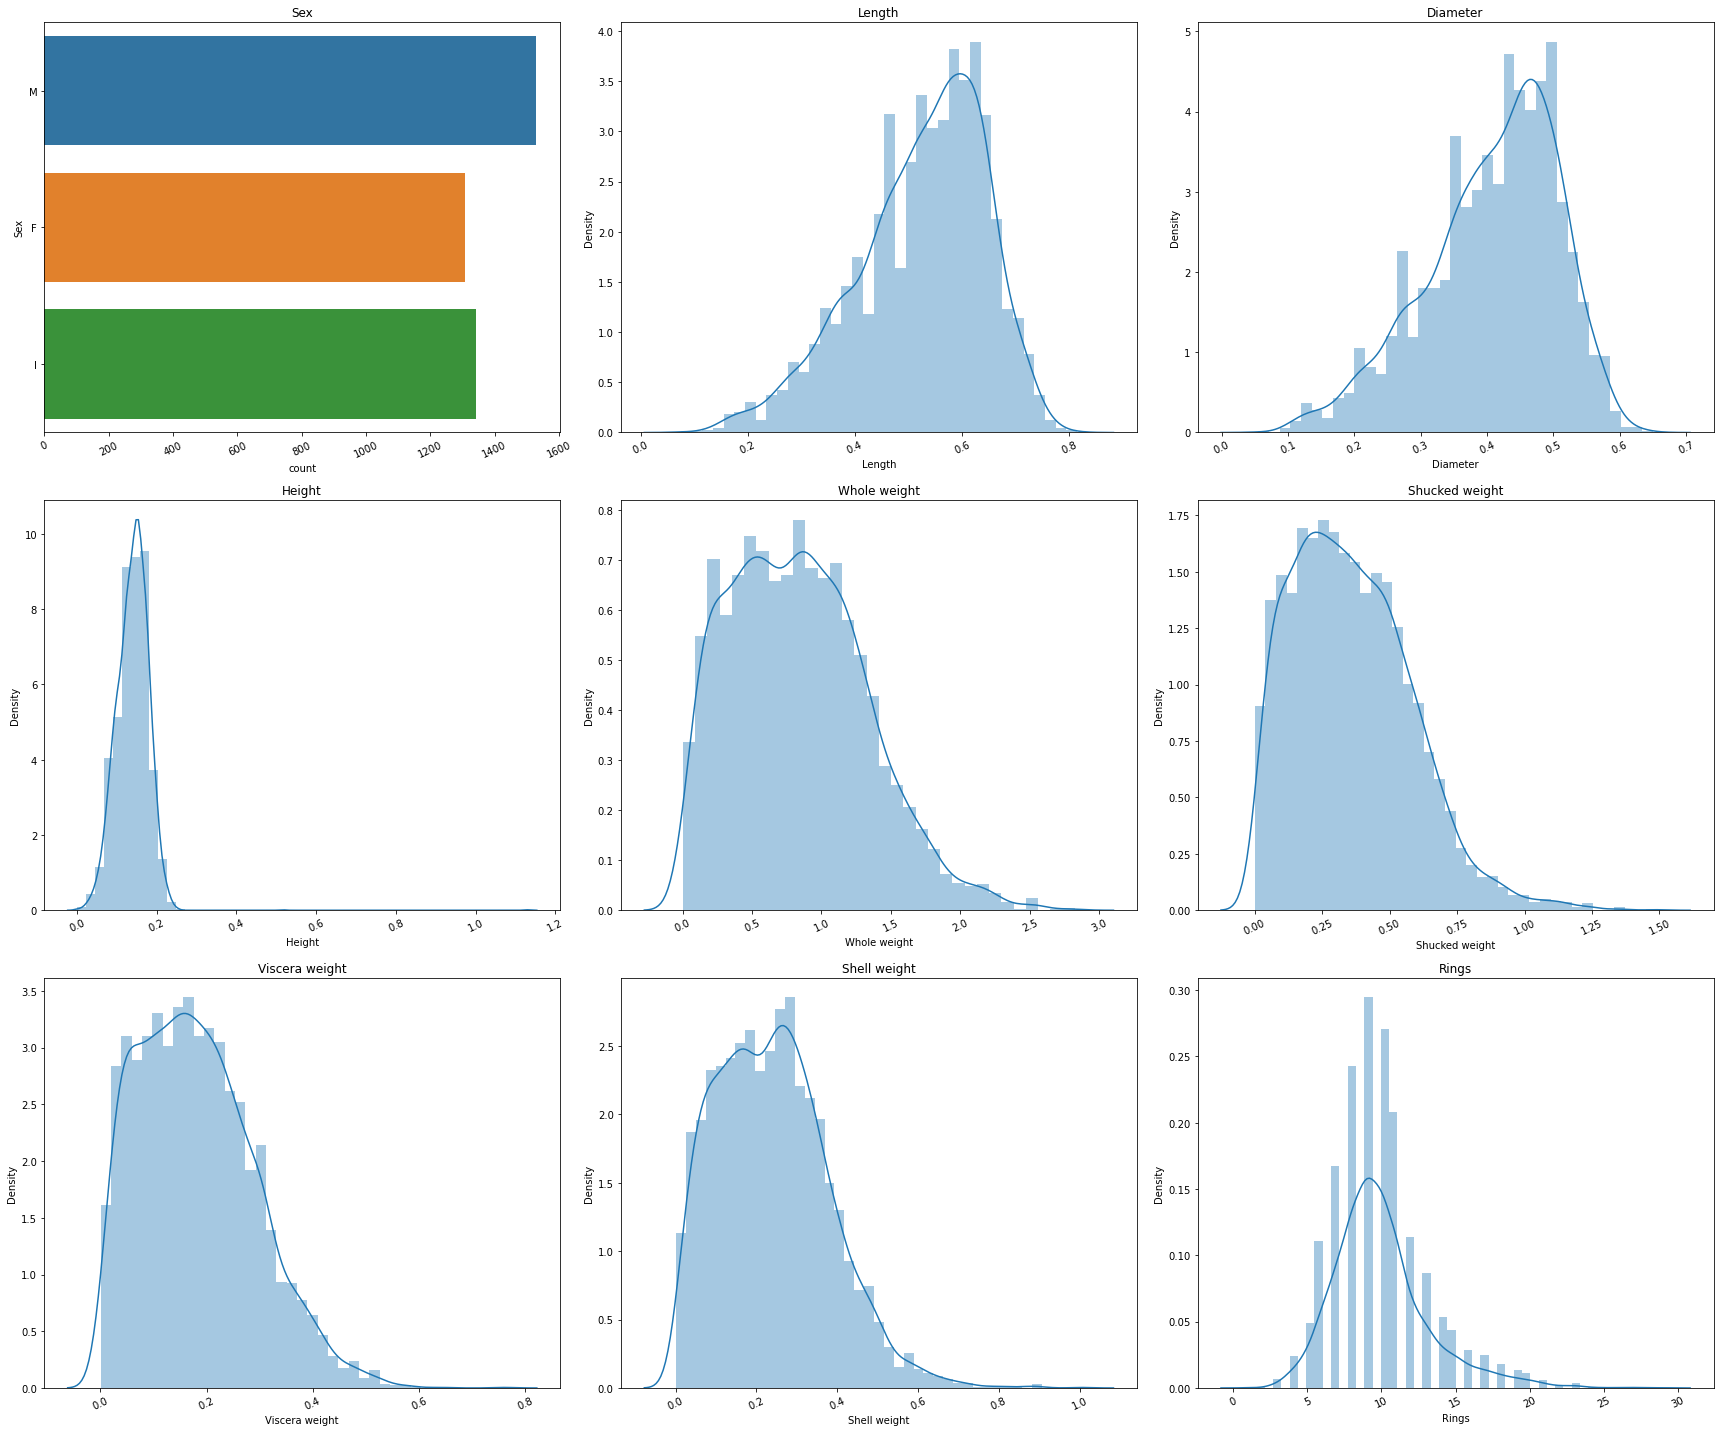

In [3]:
# 2进行数据可视化，分析各个特征
import math
def plot_distribution(dataset, cols, width, height, hspace, wspace):
    fig = plt.figure(figsize = (width, height))
    fig.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=wspace,hspace=hspace)
    rows = math.ceil(dataset.shape[1] / cols)
    for i,column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels = substrings)
            plt.xticks(rotation = 25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation = 25)
    plt.tight_layout()
plot_distribution(data, cols=3, width=24, height=20, hspace=0.2, wspace=0.5)

In [4]:
# 3改文本型数据改为数值型数据
data.loc[data['Sex']=='M','Sex'] = 0
data.loc[data['Sex']=='F','Sex'] = 1
data.loc[data['Sex']=='I','Sex'] = 2
# 改Sex列的数据类型，否则corr会不计算该列
data['Sex']=data['Sex'].astype(np.int)

transfer0 = StandardScaler() #实例化一个转换器类
xi = transfer0.fit_transform(data) #调用fit_transform()
data2 = pd.DataFrame(xi,columns=data.columns)

Rings             1.000000
Shell weight      0.627574
Diameter          0.574660
Height            0.557467
Length            0.556720
Whole weight      0.540390
Viscera weight    0.503819
Shucked weight    0.420884
Sex              -0.351822
Name: Rings, dtype: float64


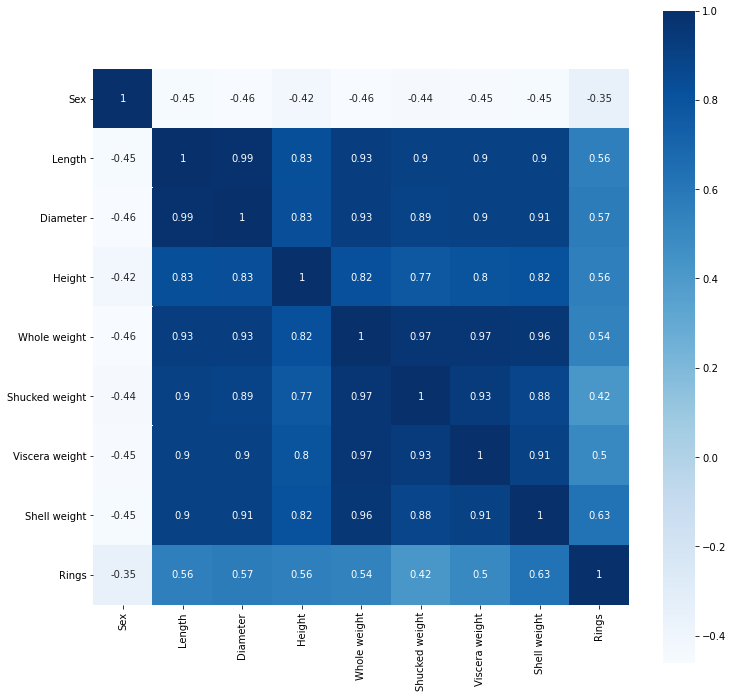

In [5]:
# 4关联度分析
corr_matrix = data2.corr()
print(corr_matrix['Rings'].sort_values(ascending=False))
# 展示各特征之间的相关性
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, vmax=1, square=True, cmap='Blues')
plt.show()

## 能发现Rings和Sex可以作为很好的分类标准，这里我们使用Sex

In [6]:
X=data.drop('Sex',axis=1).values
X

array([[ 0.455 ,  0.365 ,  0.095 , ...,  0.101 ,  0.15  , 15.    ],
       [ 0.35  ,  0.265 ,  0.09  , ...,  0.0485,  0.07  ,  7.    ],
       [ 0.53  ,  0.42  ,  0.135 , ...,  0.1415,  0.21  ,  9.    ],
       ...,
       [ 0.6   ,  0.475 ,  0.205 , ...,  0.2875,  0.308 ,  9.    ],
       [ 0.625 ,  0.485 ,  0.15  , ...,  0.261 ,  0.296 , 10.    ],
       [ 0.71  ,  0.555 ,  0.195 , ...,  0.3765,  0.495 , 12.    ]])

In [7]:
# 5.1采用PCA的方式
# 这里不删除Rings先
#来自sklearn.decomposition导入PCA
pca = PCA(n_components =3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)


In [8]:
principalDf

,0,1,2
0,5.004803,-0.866927,0.027876
1,-2.991062,-0.434572,0.041150
2,-0.946035,-0.086739,-0.063334
3,0.029437,-0.376935,0.004381
4,-2.994317,-0.466080,0.058218
...,...,...,...
4172,1.069393,-0.023664,-0.039121
4173,0.082964,0.167178,-0.026324
4174,-0.888070,0.508786,-0.013685
4175,0.099892,0.340900,-0.041644


In [9]:
a=principalDf.values

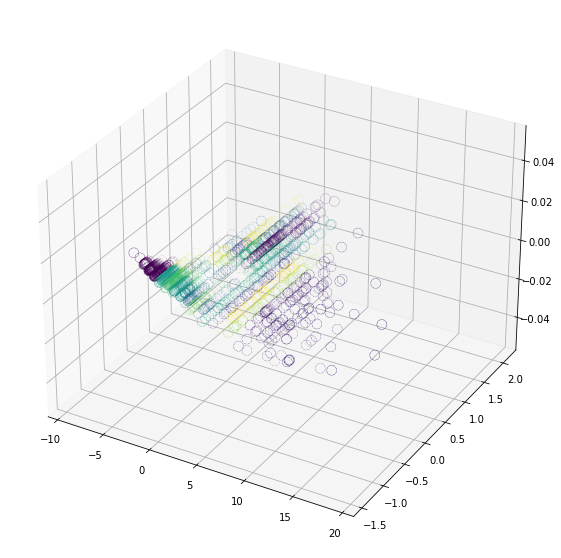

In [10]:
plt.figure(figsize = (40,10))
linewidth = 10
alpha = 0.3
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(1, 2, 1, projection='3d')
Clu=KMeans(n_clusters=37,init='random',n_init=10,max_iter=300,random_state=0)
y_clu=Clu.fit_predict(a)
plt.scatter(a[:,0],a[:,1],a[:,2],c=y_clu,linewidth=linewidth)

Text(0, 0.5, 'Silhouette Coefficient Score')

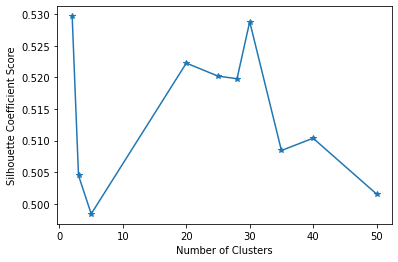

In [11]:
# 找此时最好的k值
from sklearn.metrics import silhouette_score
sc_scores = []

clusters = [2,3,5,20,25,28,30,35,40,50]                                  #簇的个数
for t in clusters:
    Clu=KMeans(n_clusters=t,init='random',n_init=10,max_iter=300,random_state=0)
    y_clu=Clu.fit_predict(a)
    sc_score = silhouette_score(a, y_clu)
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')

## 这里30附近有局部最优，也正好说明了前面的关联度分析的Rings

# 采用原数据聚类看效果


Text(0, 0.5, 'Silhouette Coefficient Score')

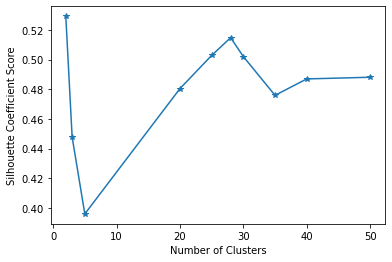

In [12]:
from sklearn.metrics import silhouette_score
sc_scores = []

clusters = [2,3,5,20,25,28,30,35,40,50]                                  #簇的个数
for t in clusters:
    Clu=KMeans(n_clusters=t,init='random',n_init=10,max_iter=300,random_state=0)
    y_clu=Clu.fit_predict(data.values)
    sc_score = silhouette_score(data.values, y_clu)
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')



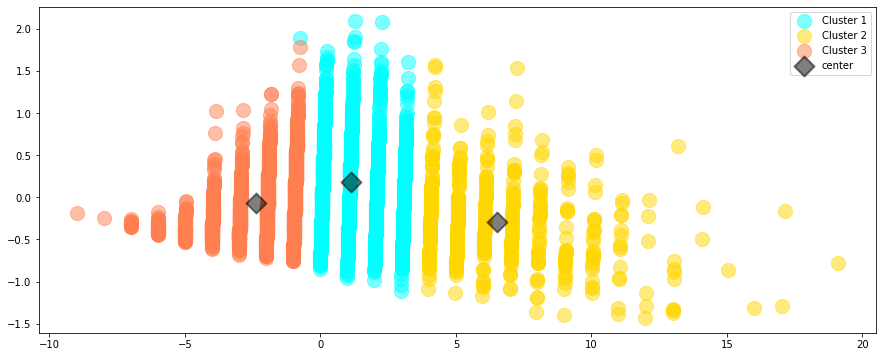

In [13]:
# 采用去掉Sex的看效果加PCA看可视化
plt.figure(1 , figsize = (15 , 6))
pca = PCA(n_components =2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
Clu=KMeans(n_clusters=3,init='random',n_init=10,max_iter=300,random_state=0)
model=Clu.fit(principalDf)
y_clu=model.predict(principalDf)
plt.scatter(principalDf.values[y_clu==0,0], principalDf.values[y_clu==0,1],  c='cyan', label='Cluster 1',s = 200 , alpha = 0.5)
plt.scatter(principalDf.values[y_clu==1,0], principalDf.values[y_clu==1,1], c='gold', label='Cluster 2',s = 200 , alpha = 0.5)
plt.scatter(principalDf.values[y_clu==2,0], principalDf.values[y_clu==2,1],  c='coral', label='Cluster 3',s = 200 , alpha = 0.5)
centers = model.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black',label='center',linewidth = 2, marker='D',s = 200 , alpha = 0.5)
plt.legend()

# 不采用PCA，选取固定特征


In [14]:
# plt.figure(figsize = (40,10))
b=data.iloc[:,1:3]
label=data.iloc[:,0]
b


,Length,Diameter
0,0.455,0.365
1,0.350,0.265
2,0.530,0.420
3,0.440,0.365
4,0.330,0.255
...,...,...
4172,0.565,0.450
4173,0.590,0.440
4174,0.600,0.475
4175,0.625,0.485


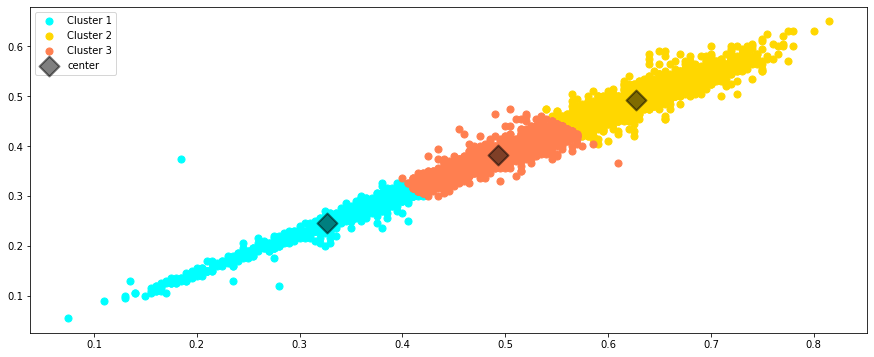

In [15]:
# 画图
plt.figure(1 , figsize = (15 , 6))
Clu=KMeans(n_clusters=3,init='random',n_init=10,max_iter=300,tol=0.0001,random_state=0)
model=Clu.fit(b.values)
y_clu=model.predict(b.values)
plt.scatter(b.values[y_clu==0,0], b.values[y_clu==0,1], s=50, c='cyan', label='Cluster 1')
plt.scatter(b.values[y_clu==1,0], b.values[y_clu==1,1], s=50, c='gold', label='Cluster 2')
plt.scatter(b.values[y_clu==2,0], b.values[y_clu==2,1], s=50, c='coral', label='Cluster 3')
centers = model.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black',label='center',linewidth = 2, marker='D',s = 200 , alpha = 0.5)
plt.legend()

In [16]:
#看分数
sc_score = silhouette_score(b, y_clu)
sc_score

0.5416207351247193

Text(0, 0.5, 'Silhouette Coefficient Score')

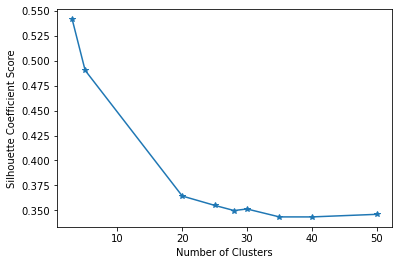

In [17]:
# 找k值
clusters = [3,5,20,25,28,30,35,40,50]  
sc_scores=[]
#簇的个数
for t in clusters:
    Clu=KMeans(n_clusters=t,init='random',n_init=10,max_iter=300,random_state=0)
    y_clu=Clu.fit_predict(b)
    sc_score = silhouette_score(b, y_clu)
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')

# 实现KMeans

In [18]:
# 加载包并测试
import torch
torch.rand(1)

tensor([0.1948])

## 自定义函数
流程：

（1）为每个聚类选择一个初始聚类中心；

（2）将样本集按照最小距离原则分配到最邻近聚类；

（3）使用每个聚类的样本均值更新聚类中心；

（4）重复步骤（2）、（3），直到聚类中心不再发生变化；

（5）输出最终的聚类中心和 k 个簇划分（作图）；


In [19]:
class My_KMeans():
    def __init__(self, n_clusters=20, max_iter=1000, verbose=True):
        """
        @初始化
        @n_clusters
        @return
        """
        self.n_cluster = n_clusters
        self.n_clusters = n_clusters
        self.labels = None
        self.dists = None  # shape: [x.shape[0],n_cluster]
        self.centers = None
      #  self.variation = torch.Tensor([float("Inf")]).to(device)
        self.verbose = verbose
        self.started = False
        self.representative_samples = None
        self.max_iter = max_iter
        self.count = 0
        print('簇数:',self.n_clusters)
        
        
    def fit(self, x):    
        """
        实现过程
        @x:训练的数据集，参考sklearn，数据类型为DataFrame
        @: 返回聚类中心
        """
        #   dataframe.shape()
        # 返回形状，即几行几列的数组，如[2,3],shape[0]=rows,shape[1]=columns
        rows=x.shape[0]
        columns=x.shape[1]
        
        # （1）为每个聚类选择一个初始聚类中心；
        # 即随机生成n_clusters个中心
        # https://blog.csdn.net/yangwangnndd/article/details/106524093
        
        i_row = torch.randint(0,rows, (self.n_clusters,))
        i_points=x[i_row]
        self.centers=torch.tensor(i_points,dtype=torch.float)
#         print('初始聚类中心:\n',i_points)
        iter=0
        while(True):
            iter+=1
            
            if(iter>self.max_iter):
                print('超过最大迭代次数')
                break
            else:
                print('迭代次数:',iter)
            # （2）将样本集按照最小距离原则分配到最邻近聚类；
            # 即遍历data
            labels = torch.empty((x.shape[0],)).long()
            dists = torch.empty((0, self.n_clusters))
#             print('本轮的簇类中心是',self.centers)
            for i, sample in enumerate(x):
                # 计算距离
                # 注意torch计算需要类型转换为张量
                sample=torch.tensor(sample)
               # print(type(sample))
              #  print(type(self.centers))
                dist = torch.sum(torch.mul(sample - self.centers, sample - self.centers), (1))
#                 print('当前计算点%',i)
#                 print('和簇类中心集的距离向量:',dist)
                # 分配到最小索引
                # https://blog.csdn.net/sinat_37145472/article/details/94753866
                labels[i] = torch.argmin(dist)
#                 print('它离%d最近'%(labels[i]))
                dists = torch.cat([dists, dist.unsqueeze(0)], (0))
#                 print('更新距离矩阵',dists)
            # 最终labels更新
            self.labels = labels
#             print('本轮最终的标签输出是',self.labels)
            ##
            self.dists = dists
            #
            ##
        #    break
        #（3）使用每个聚类的样本均值更新聚类中心；
            # torch初始化向量
            # https://www.jianshu.com/p/d1a9916ccfe8
            
            # 簇类中心集是n_clusters X columns 的矩阵
            new_centers = torch.empty((self.n_clusters, columns))
            
            # 一共更新n_clusters个centers
            for i in range(self.n_clusters):
                # 找到该中心的周围的点的索引
                mask = self.labels == i
                # 找到他们
                cluster_samples = torch.tensor(x[mask])
#                 print(mask)
#                 print('属于该中心的点',cluster_samples)
                # 计算新一轮的队列中心
                new_centers[i] = torch.mean(cluster_samples, (0),dtype=torch.float)
#                 print('计算的新中心',new_centers[i])
                # 如果没有属于该中心的点，保持原状
#                 print(torch.isnan(new_centers[i]).int().sum()>0)
                if(torch.isnan(new_centers[i]).int().sum()>0):
                    new_centers[i]=self.centers[i]
            print('原中心',self.centers)
            print('新的中心',new_centers)
        #（4）重复步骤（2）、（3），直到聚类中心不再发生变化；
            if(torch.equal(new_centers, self.centers)):
                break
            else:
                self.centers = new_centers
        #（5）输出最终的聚类中心和 k 个簇划分（作图）；
        print('#############################')
        print('最终结果（中心点）',self.centers)
#         print('它们包含的点')
#         for i in range(self.n_clusters):
#             mask = self.labels == i
#             # 找到他们
#             cluster_samples = torch.tensor(x[mask])
#             print(mask)
#             print('属于该中心的点',cluster_samples)            
        print('迭代次数:',iter)
        print('#############图像############')
        plt.figure( figsize = (15 , 6))
        for i in range(0,columns-1):
            for j in range(i+1,columns):
                plt.figure(j+i*10, figsize = (15 , 6))
                plt.scatter(x[:,i],x[:,j],c=self.labels,linewidth=1,alpha = 0.5)
                plt.scatter(self.centers[:,0], self.centers[:, 1], c='black',linewidth =3, s=80, marker='D')
        
        return self.centers
            

In [20]:
# 生成测试数据
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=400, centers=3, n_features=2,
                   random_state=0)
print(X[1:10])
print(y[1:10])

[[-1.89760802  1.97226647]
 [ 2.11567076  3.06896151]
 [ 1.40252881  4.98069536]
 [-0.21258918  3.79697097]
 [ 2.15299249  1.48061734]
 [ 2.6225578   0.67498856]
 [-2.05960681  4.008632  ]
 [-2.11830668  4.04230145]
 [ 2.8285205  -0.28621698]]
[2 0 0 0 1 1 2 2 1]


In [21]:
# 初始化
test=My_KMeans(n_clusters=3)

簇数: 3


迭代次数: 1
原中心 tensor([[ 1.2726,  0.7873],
        [-0.1712,  3.8660],
        [-1.6173,  4.2855]])
新的中心 tensor([[ 1.6958,  0.8879],
        [ 0.5971,  4.0503],
        [-2.0658,  3.0665]])
迭代次数: 2
原中心 tensor([[ 1.6958,  0.8879],
        [ 0.5971,  4.0503],
        [-2.0658,  3.0665]])
新的中心 tensor([[ 1.9340,  0.8206],
        [ 0.8097,  4.2543],
        [-1.8092,  2.7314]])
迭代次数: 3
原中心 tensor([[ 1.9340,  0.8206],
        [ 0.8097,  4.2543],
        [-1.8092,  2.7314]])
新的中心 tensor([[ 1.9665,  0.8125],
        [ 0.8386,  4.2985],
        [-1.7329,  2.7076]])
迭代次数: 4
原中心 tensor([[ 1.9665,  0.8125],
        [ 0.8386,  4.2985],
        [-1.7329,  2.7076]])
新的中心 tensor([[ 1.9833,  0.8099],
        [ 0.8591,  4.3279],
        [-1.6838,  2.7006]])
迭代次数: 5
原中心 tensor([[ 1.9833,  0.8099],
        [ 0.8591,  4.3279],
        [-1.6838,  2.7006]])
新的中心 tensor([[ 1.9833,  0.8099],
        [ 0.8641,  4.3405],
        [-1.6696,  2.6996]])
迭代次数: 6
原中心 tensor([[ 1.9833,  0.8099],
        [ 0.8641,  4.3405

tensor([[ 1.9787,  0.8231],
        [ 0.8430,  4.3603],
        [-1.6704,  2.6795]])

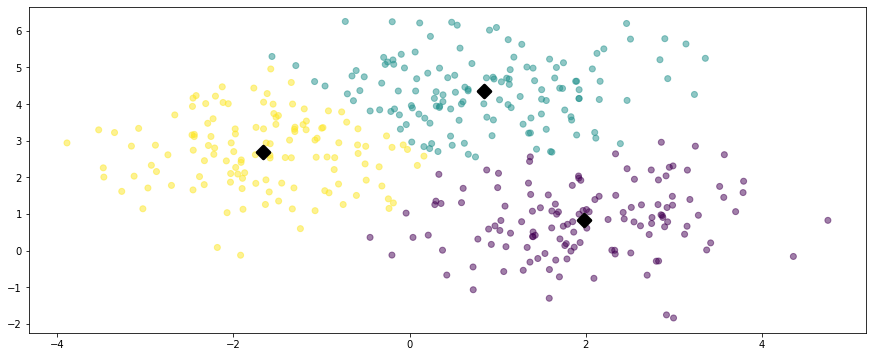

In [22]:
# 调用函数
test.fit(X)

In [23]:
# 生成测试数据
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, 
                  centers=3,
                  n_features=4,
                   random_state=0)
print(X[1:10])
print(y[1:10])

[[ 9.21466866 -2.64871272  4.20207746  0.51076424]
 [ 3.35941485  5.24826681  1.1424453   2.01467995]
 [-0.65794053  3.19475417 -2.21936035  8.15027722]
 [-3.89649092  3.78193456 -3.48785983  8.23695907]
 [ 2.20656076  5.50616718  1.6679407   0.59536091]
 [-1.48827346  1.26116716 -2.23376651  6.36362501]
 [-2.70606194  4.21931033 -0.3529955   9.21042408]
 [ 1.18454506  5.28042636  2.41163392  1.60423683]
 [-0.664308    0.26226317  0.26507231  8.38859208]]
[2 0 1 1 0 1 1 0 1]


In [24]:
# 初始化
test=My_KMeans(n_clusters=3)

簇数: 3


迭代次数: 1
原中心 tensor([[ 8.3343, -1.3141,  7.2575,  0.9740],
        [ 0.6223,  2.9288,  1.4116, -1.3257],
        [ 7.4490, -2.0276,  6.6072, -1.0837]])
新的中心 tensor([[ 9.0963, -2.3953,  5.9635,  0.9565],
        [-0.3187,  3.4748,  0.2518,  4.4656],
        [ 8.7253, -2.6414,  5.8294, -0.5712]])
迭代次数: 2
原中心 tensor([[ 9.0963, -2.3953,  5.9635,  0.9565],
        [-0.3187,  3.4748,  0.2518,  4.4656],
        [ 8.7253, -2.6414,  5.8294, -0.5712]])
新的中心 tensor([[ 8.9629, -2.4839,  5.8642,  1.0217],
        [-0.3187,  3.4748,  0.2518,  4.4656],
        [ 8.9752, -2.4753,  6.0220, -0.7712]])
迭代次数: 3
原中心 tensor([[ 8.9629, -2.4839,  5.8642,  1.0217],
        [-0.3187,  3.4748,  0.2518,  4.4656],
        [ 8.9752, -2.4753,  6.0220, -0.7712]])
新的中心 tensor([[ 8.9612, -2.4919,  5.8676,  1.0033],
        [-0.3187,  3.4748,  0.2518,  4.4656],
        [ 8.9794, -2.4579,  6.0222, -0.8170]])
迭代次数: 4
原中心 tensor([[ 8.9612, -2.4919,  5.8676,  1.0033],
        [-0.3187,  3.4748,  0.2518,  4.4656],
        [ 8

tensor([[ 8.9612, -2.4919,  5.8676,  1.0033],
        [-0.3187,  3.4748,  0.2518,  4.4656],
        [ 8.9794, -2.4579,  6.0222, -0.8170]])

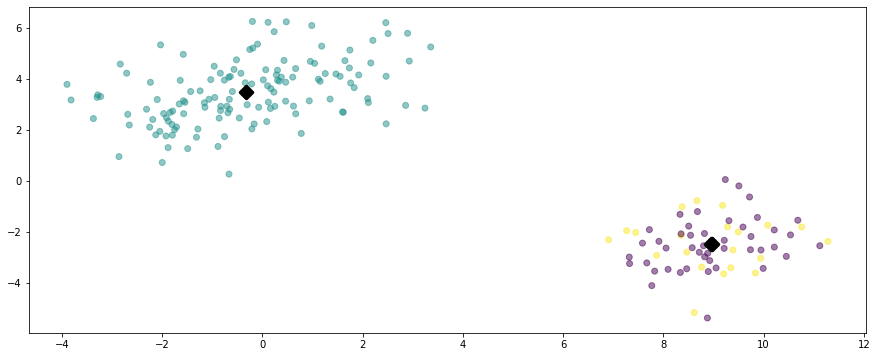

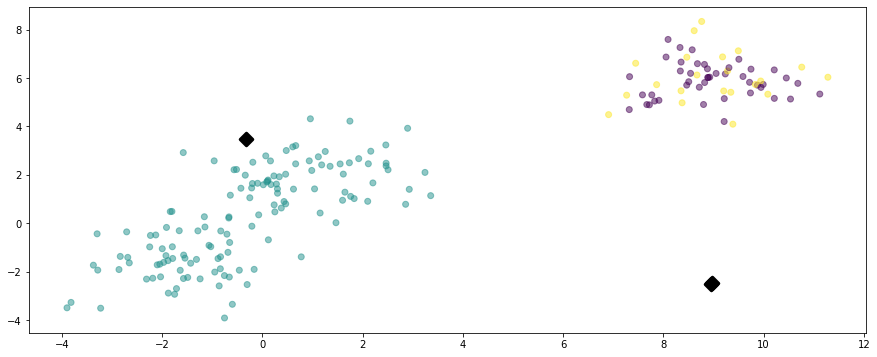

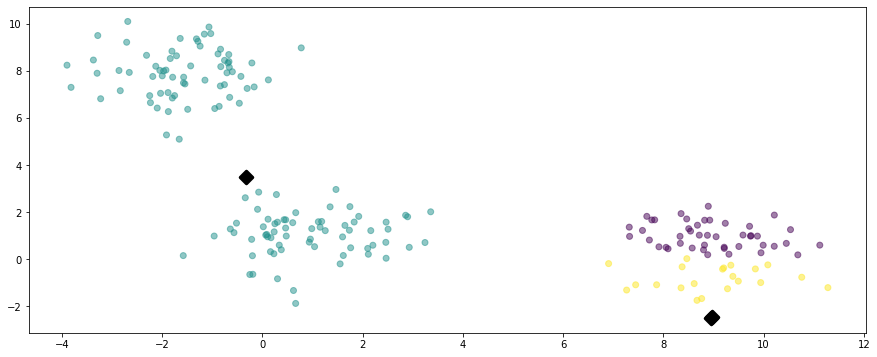

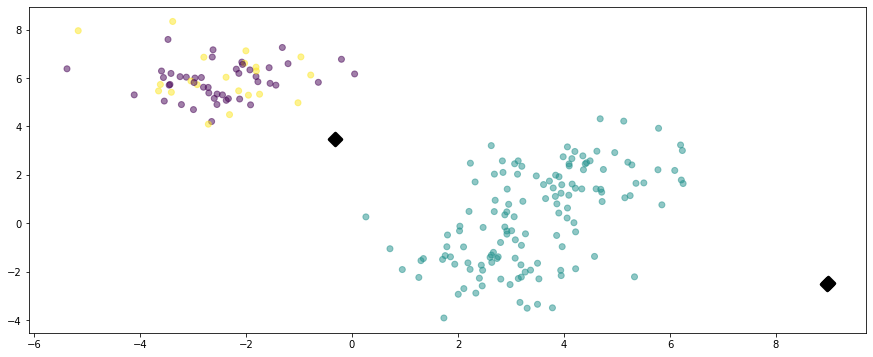

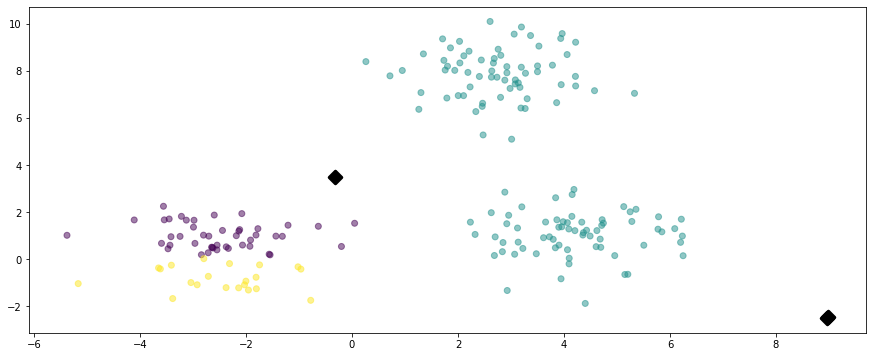

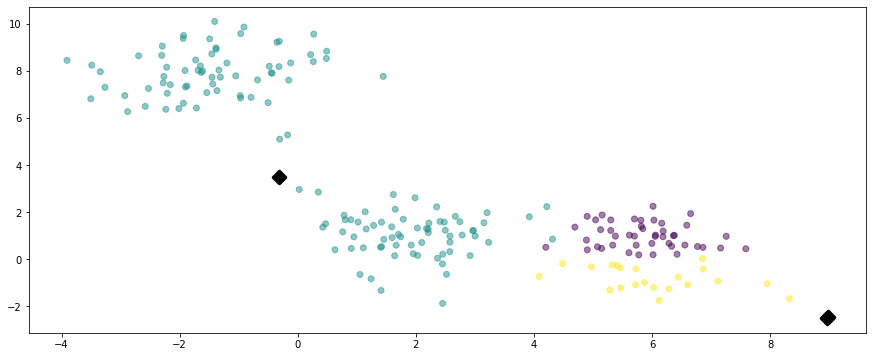

In [25]:
# 调用函数
test.fit(X)

# 完成